In [1]:
import sys
sys.path.append("/home/jinseuk56/Desktop/github_repo/AEs/VAE/")
from VAEs_module import *
import time
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import ipywidgets as pyw
import tkinter.filedialog as tkf
import tifffile
from tabulate import tabulate
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import linalg as LA

In [2]:
file_adr = tkf.askopenfilenames()
print(*file_adr, sep="\n")

/home/jinseuk56/Desktop/data_repo/20230328_WSe2/test.tif


In [3]:
data_load = load_data(file_adr, dat_dim=4, dat_unit='1/nm', rescale=False)

(15, 34, 128, 128)


[[64.0, 65.0]]


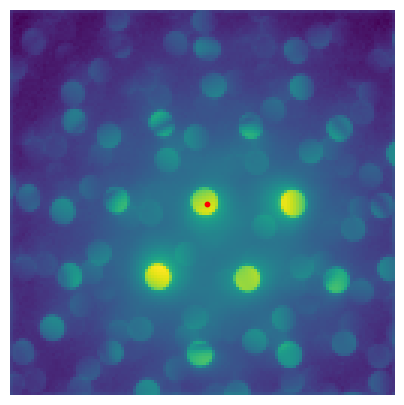

In [4]:
data_load.find_center(cbox_edge=10, center_remove=0, result_visual=True, log_scale=True)

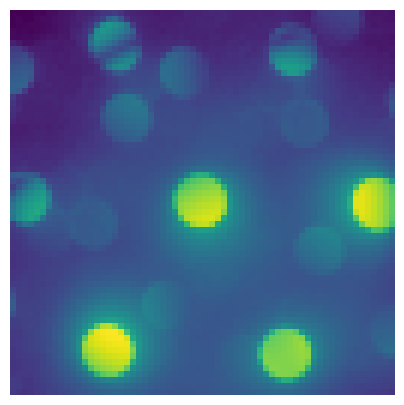

(15, 34, 64, 64)
(510, 64, 64)
0.0 1.0
1e-06 1.0


In [5]:
data_load.make_input(min_val=1E-6, max_normalize=True, 
           log_scale=False, radial_flat=False, 
           w_size=32, radial_range=None, final_dim=2)

In [6]:
if torch.cuda.is_available():
    print("%d gpu available"%(torch.cuda.device_count()))
    cuda_device = torch.device("cuda:0")
    print(torch.cuda.get_device_name(cuda_device))
    torch.cuda.set_device(cuda_device)
    print(torch.cuda.memory_summary(device=cuda_device))
else:
    cuda_device = None

2 gpu available
Tesla V100S-PCIE-32GB
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 1                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool | 

In [7]:
num_comp = 2
channels = [32, 64, 128, 256]
kernels = [4, 4, 4, 4]
padding = [1, 1, 1, 1]
stride = [2, 2, 2, 2]
pooling = [1, 1, 1, 1]

dat_dim = []
tmp_dim = data_load.w_size*2
for i in range(len(kernels)):
    tmp_dim += (-kernels[i]+2*padding[i])
    tmp_dim /= stride[i]
    tmp_dim += 1
    tmp_dim /= pooling[i]
    dat_dim.append(int(tmp_dim))

print(dat_dim)
print(kernels)
print(channels)
print(padding)
print(stride)
print(pooling)

[32, 16, 8, 4]
[4, 4, 4, 4]
[32, 64, 128, 256]
[1, 1, 1, 1]
[2, 2, 2, 2]
[1, 1, 1, 1]


In [8]:
parallel_ = True

enc_model = VAE2DCNN_encoder(dat_dim[-1], channels, kernels, stride, padding, pooling, num_comp)
if parallel_:
    enc_model = nn.DataParallel(enc_model)
enc_model.cuda(cuda_device)
print(enc_model)

DataParallel(
  (module): VAE2DCNN_encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Tanh()
      (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Tanh()
      (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): Tanh()
      (12): Flatten(start_dim=1, end_dim=-1)
      (13): Linear(in_features=4096, out_features=4, bias=True)
    )
  )
)


In [9]:
dec_kernel = [4, 4, 4, 4]
dec_stride = [2, 2, 2, 2]
dec_padding = [1, 1, 1, 1]
dec_outpad = [0, 0, 1, 1]

dec_dim = []
enc_dim = dat_dim[-1]
for i in range(len(dec_kernel)):
    enc_dim = (enc_dim-1)*dec_stride[i] + dec_kernel[i] - 2*dec_padding[i] + dec_outpad[i]
    dec_dim.append(enc_dim)
    
print(dec_dim)

dec_kernel.reverse()
dec_stride.reverse()
dec_padding.reverse()
dec_outpad.reverse()

final_kernel = 4
print(dec_dim[-1] - final_kernel + 1)

[8, 16, 33, 67]
64


In [10]:
dec_model = VAE2DCNN_decoder(num_comp, dat_dim[-1], channels, 
                             dec_kernel, dec_stride, dec_padding, dec_outpad, 
                             final_kernel)

if parallel_:
    dec_model = nn.DataParallel(dec_model)
    
dec_model.cuda(cuda_device)
print(dec_model)

DataParallel(
  (module): VAE2DCNN_decoder(
    (init_decoder): Linear(in_features=2, out_features=4096, bias=True)
    (decoder): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Tanh()
      (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Tanh()
      (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (10): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): Tanh()
      (12): Conv2d(1, 1, ke

In [11]:
batch_size = 510
mini_batches = [data_load.dataset_input[k:k+batch_size] for k in range(0, len(data_load.dataset_input), batch_size)]
print(len(mini_batches))
print(len(mini_batches[-1]))

1
510


In [12]:
glob_iter = 0
params = list(enc_model.parameters()) + list(dec_model.parameters())
optimizer = optim.Adam(params)

In [13]:
start = time.time()
n_fig = 5
n_epoch = 1000

beta = 4.0
gamma = 1000
C_max = torch.Tensor([25.0]).to(cuda_device)
C_stop_iter = int(n_epoch/3)

l_rate = 0.001
optimizer.param_groups[0]['lr'] = l_rate

loss_plot = []
for epoch in range(n_epoch):
    glob_iter += 1
    loss_epoch = 0
    recon_loss = 0
    KLD_loss = 0
    
    latent_z = []
    z_mu = []
    z_logvar = []

    for i, m_batch in enumerate(mini_batches):
        x = torch.from_numpy(m_batch).clamp_(min=1E-6, max=0.999999)
        x = x.to(torch.float32)
        x = x.to(cuda_device)
        x.requires_grad_(requires_grad=False)
        
        mu, logvar, z = enc_model(x)
        x_ = dec_model(z)

        reconstruction_error = reconstruction_loss(x_.squeeze(), x, mean=False, loss_fn="BCE")
        KL_divergence = VAE_KLD(mu, logvar, mean=False, mode="normal", beta=beta,
                                gamma=gamma, C_max=C_max, C_stop_iter=C_stop_iter, glob_iter=glob_iter)
        
        loss = reconstruction_error + KL_divergence
        loss_epoch += loss.item()
        recon_loss += reconstruction_error.item()
        KLD_loss += KL_divergence.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        latent_z.extend(z.data.cpu().numpy().tolist())
        z_mu.extend(mu.data.cpu().numpy().tolist())
        z_logvar.extend(logvar.data.cpu().numpy().tolist())
    
    loss_plot.append(loss_epoch/data_load.total_num)       
    
    latent_z = np.asarray(latent_z)
    z_mu = np.asarray(z_mu)
    z_logvar = np.asarray(z_logvar)
            
    if epoch == 0:
        print(torch.cuda.memory_summary(device=cuda_device))
        
    if (epoch+1) % int(n_epoch/10) == 0:
        fig, ax = plt.subplots(1, 1)
        ax.plot(np.arange(epoch+1)+1, loss_plot, "k-")
        ax.grid()
        plt.show()        
        
        print(tabulate([
                        ["epoch", epoch+1], 
                        ["total loss", loss_epoch/data_load.total_num],
                        ["reconstruction error", recon_loss/data_load.total_num],
                        ["KL divergence", KLD_loss/data_load.total_num],
                        ["error ratio", reconstruction_error/KL_divergence],
                        ["iteration ratio", C_stop_iter/glob_iter]
                        ]))
        print("%.2f minutes have passed"%((time.time()-start)/60))
        
        fig, ax = plt.subplots(2, n_fig, figsize=(5*n_fig, 5*2))
        for i in range(n_fig):
            ax[0][i].imshow(x[i].data.cpu(), cmap="inferno")
            ax[1][i].imshow(x_[i].squeeze().data.cpu(), cmap="inferno")
        fig.tight_layout()
        plt.show()
        
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        coeffs = np.zeros_like(latent_z)
        coeffs[data_load.ri] = latent_z.copy()
        latent_z_coeffs_reshape = reshape_coeff(coeffs, data_load.data_shape)  

        ax[0].set_title("latent z distribution")
        for i in range(num_comp):
            ax[0].hist(coeffs[:, i], bins=50, alpha=(1.0-i*(1/num_comp)))

        coeffs = np.zeros_like(z_mu)
        coeffs[data_load.ri] = z_mu.copy()
        z_mu_coeffs_reshape = reshape_coeff(coeffs, data_load.data_shape)

        ax[1].set_title("z mu distribution")
        for i in range(num_comp):
            ax[1].hist(coeffs[:, i], bins=50, alpha=(1.0-i*(1/num_comp)))

        coeffs = np.zeros_like(z_logvar)
        coeffs[data_load.ri] = z_logvar.copy()
        z_logvar_coeffs_reshape = reshape_coeff(coeffs, data_load.data_shape) 

        ax[2].set_title("z log(var) distribution")
        for i in range(num_comp):
            ax[2].hist(coeffs[:, i], bins=50, alpha=(1.0-i*(1/num_comp)))       

        plt.show()

        for i in range(data_load.num_img):
            fig, ax = plt.subplots(3, num_comp, figsize=(5*num_comp, 15))
            for j in range(num_comp):
                tmp = ax[0][j].imshow(latent_z_coeffs_reshape[i][:, :, j], cmap="inferno")
                ax[0][j].axis("off")
                tmp = ax[1][j].imshow(z_mu_coeffs_reshape[i][:, :, j], cmap="inferno")
                ax[1][j].axis("off")
                tmp = ax[2][j].imshow(z_logvar_coeffs_reshape[i][:, :, j], cmap="inferno")
                ax[2][j].axis("off")
            plt.show()  
        
print("The training has been finished.")

RuntimeError: module must have its parameters and buffers on device cuda:0 (device_ids[0]) but found one of them on device: cuda:1

In [ ]:
save_result = False

for i in range(data_load.num_img):
    fig, ax = plt.subplots(1, num_comp, figsize=(5*num_comp, 5))
    for j in range(num_comp):
        tmp = ax[j].imshow(z_mu_coeffs_reshape[i][:, :, j], cmap="inferno")
        ax[j].axis("off")
        if save_result:
            tifffile.imwrite("z_mu_comp_%d.tif"%(j+1), z_mu_coeffs_reshape[i][:, :, j])
    plt.show()

In [ ]:
save_result = False

for i in range(data_load.num_img):
    fig, ax = plt.subplots(1, num_comp, figsize=(5*num_comp, 5))
    for j in range(num_comp):
        tmp = ax[j].imshow(z_logvar_coeffs_reshape[i][:, :, j], cmap="inferno")
        ax[j].axis("off")
        if save_result:
            tifffile.imwrite("z_mu_comp_%d.tif"%(j+1), z_logvar_coeffs_reshape[i][:, :, j])
    plt.show()

In [ ]:
%matplotlib inline

In [ ]:
%matplotlib widget

In [ ]:
n_sample = 20
sigma = 5.0
z_test = np.linspace(-sigma, sigma, n_sample*10, endpoint=True)
rv = stats.norm(0, 1)
norm_pdf = rv.pdf(z_test)
norm_pdf = norm_pdf / np.sum(norm_pdf)
z_test = np.sort(np.random.choice(z_test, n_sample, replace=False, p=norm_pdf))
z_test = np.meshgrid(z_test, z_test)
z_test = np.stack((z_test[0].flatten(), z_test[1].flatten()), axis=1)
print(z_test.shape)
z_test = torch.from_numpy(z_test).to(torch.float32).to(cuda_device)

In [ ]:
dec_model.eval()
generated = dec_model(z_test)
print(generated.shape)

In [ ]:
fig, ax = plt.subplots(n_sample, n_sample, figsize=(30, 30))
for i, a in enumerate(ax.flat):
    a.imshow(generated[i].squeeze().data.cpu(), cmap="jet")
    a.axis("off")
plt.subplots_adjust(hspace=0.01, wspace=0.01)
plt.show()

In [ ]:
# 2D subspace
%matplotlib widget
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

def projection(c1, c2):
    ax.cla()
    ax.scatter(coeffs[:, c1], coeffs[:, c2], s=30, c="black", alpha=0.5)
    ax.grid()
    ax.set_xlabel("loading vector %d"%(c1+1), fontsize=15)
    ax.set_ylabel("loading vector %d"%(c2+1), fontsize=15)
    ax.tick_params(axis="both", labelsize=15)
    fig.canvas.draw()
    fig.tight_layout()

x_widget = pyw.IntSlider(min=0, max=num_comp-1, step=1, value=0)
y_widget = pyw.IntSlider(min=0, max=num_comp-1, step=1, value=1)

pyw.interact(projection, c1=x_widget, c2=y_widget)
plt.show()